In [21]:
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
import glob
import gc
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm  
import matplotlib.pyplot as plt
import random

In [3]:
# ⚙️ CONFIGURATION
# We will train these 4 categories
TARGET_CATEGORIES = ["leather", "metal_nut", "bottle", "zipper"] 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
MAX_MEMORY_BANK_SIZE = 15000 

print(f"✅ Running on: {DEVICE}")
print(f"✅ Targets: {TARGET_CATEGORIES}")

✅ Running on: cuda
✅ Targets: ['leather', 'metal_nut', 'bottle', 'zipper']


In [4]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split='train', size=320):
        self.size = size
        self.images = []
        self.labels = []
        
        # Check paths for different Kaggle dataset versions
        base_path = os.path.join(root_dir, category)
        
        if split == 'train':
            self.images = glob.glob(os.path.join(base_path, 'train', 'good', '*.png'))
            self.labels = [0] * len(self.images)
        else:
            test_dir = os.path.join(base_path, 'test')
            defect_types = os.listdir(test_dir)
            for d_type in defect_types:
                img_paths = glob.glob(os.path.join(test_dir, d_type, '*.png'))
                self.images.extend(img_paths)
                label = 0 if d_type == 'good' else 1
                self.labels.extend([label] * len(img_paths))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size))
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

In [6]:
def get_dataloaders(category):
    # Try common Kaggle paths
    root_dir = '/kaggle/input/mvtec-ad' 
        
    train_ds = MVTecDataset(root_dir, category, split='train')
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_ds = MVTecDataset(root_dir, category, split='test')
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
    return train_loader, test_loader

In [7]:
def get_backbone():
    backbone = models.wide_resnet50_2(weights="DEFAULT")
    backbone.eval().to(DEVICE)
    features = []
    def hook_fn(module, input, output):
        features.append(output)
    backbone.layer2.register_forward_hook(hook_fn)
    backbone.layer3.register_forward_hook(hook_fn)
    return backbone, features

In [8]:
def aggregate_features(features):
    f2, f3 = features[0], features[1]
    f3_resized = F.interpolate(f3, size=f2.shape[-2:], mode='bilinear', align_corners=False)
    return torch.cat((f2, f3_resized), dim=1)

In [9]:
def build_memory_bank(backbone, features_storage, train_loader):
    print("   🧠 Training: Extracting features...")
    memory_bank_list = []
    mean = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1, 3, 1, 1)

    with torch.no_grad():
        for imgs, _ in tqdm(train_loader, desc="Extracting"):
            imgs = imgs.to(DEVICE)
            imgs = (imgs - mean) / std
            
            features_storage.clear()
            _ = backbone(imgs)
            feat = aggregate_features(features_storage)
            
            # Flatten features
            b, c, h, w = feat.shape
            feat = feat.permute(0, 2, 3, 1).reshape(-1, c)
            memory_bank_list.append(feat.cpu())
            
    full_bank = torch.cat(memory_bank_list, dim=0)
    
    # Subsample to save RAM
    if full_bank.shape[0] > MAX_MEMORY_BANK_SIZE:
        indices = torch.randperm(full_bank.shape[0])[:MAX_MEMORY_BANK_SIZE]
        memory_bank = full_bank[indices]
    else:
        memory_bank = full_bank
        
    print(f"   ✅ Memory Bank Ready: {memory_bank.shape}")
    return memory_bank.to(DEVICE)

In [10]:
def evaluate_model(backbone, features_storage, memory_bank, test_loader):
    print("   📊 Evaluating on Test Set...")
    y_true, y_scores = [], []
    mean = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1, 3, 1, 1)
    
    with torch.no_grad():
        for imgs, label in tqdm(test_loader, desc="Testing"):
            imgs = imgs.to(DEVICE)
            imgs = (imgs - mean) / std
            
            features_storage.clear()
            _ = backbone(imgs)
            feat = aggregate_features(features_storage)
            
            b, c, h, w = feat.shape
            feat_flat = feat.permute(0, 2, 3, 1).reshape(-1, c)
            
            # Calculate distance to nearest normal feature
            dist_matrix = torch.cdist(feat_flat, memory_bank)
            min_dist, _ = dist_matrix.min(dim=1)
            score = torch.topk(min_dist, 9).values.mean().item()
            
            y_true.append(label.item())
            y_scores.append(score)
            
    auroc = roc_auc_score(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"   🏆 AUROC: {auroc:.4f}")
    print(f"   ⚖️ Optimal Threshold: {optimal_threshold:.4f}")
    return optimal_threshold, auroc

In [11]:
def save_model(category, memory_bank, threshold, auroc):
    filename = f"patchcore_{category}.pth"
    save_dict = {
        'memory_bank': memory_bank.cpu(),
        'threshold': threshold,
        'backbone': 'wide_resnet50_2',
        'auroc': auroc
    }
    torch.save(save_dict, filename)
    print(f"   💾 Saved: {filename}")

In [12]:
# Main Loop
for category in TARGET_CATEGORIES:
    print(f"\n{'='*40}")
    print(f"🚀 STARTING: {category.upper()}")
    print(f"{'='*40}")
    
    try:
        # 1. Setup
        train_loader, test_loader = get_dataloaders(category)
        backbone, features = get_backbone()
        
        # 2. Train
        memory_bank = build_memory_bank(backbone, features, train_loader)
        
        # 3. Evaluate
        thresh, auroc = evaluate_model(backbone, features, memory_bank, test_loader)
        
        # 4. Save
        save_model(category, memory_bank, thresh, auroc)
        
        # 5. Cleanup Memory
        del backbone, memory_bank, features
        torch.cuda.empty_cache()
        gc.collect()
        
    except Exception as e:
        print(f"❌ Error on {category}: {e}")


🚀 STARTING: LEATHER
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth


100%|██████████| 263M/263M [00:01<00:00, 230MB/s]  


   🧠 Training: Extracting features...


Extracting: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it]


   ✅ Memory Bank Ready: torch.Size([15000, 1536])
   📊 Evaluating on Test Set...


Testing: 100%|██████████| 124/124 [00:11<00:00, 10.82it/s]


   🏆 AUROC: 0.9986
   ⚖️ Optimal Threshold: 28.4753
   💾 Saved: patchcore_leather.pth

🚀 STARTING: METAL_NUT
   🧠 Training: Extracting features...


Extracting: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


   ✅ Memory Bank Ready: torch.Size([15000, 1536])
   📊 Evaluating on Test Set...


Testing: 100%|██████████| 115/115 [00:07<00:00, 14.68it/s]


   🏆 AUROC: 0.9839
   ⚖️ Optimal Threshold: 35.0246
   💾 Saved: patchcore_metal_nut.pth

🚀 STARTING: BOTTLE
   🧠 Training: Extracting features...


Extracting: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


   ✅ Memory Bank Ready: torch.Size([15000, 1536])
   📊 Evaluating on Test Set...


Testing: 100%|██████████| 83/83 [00:05<00:00, 14.42it/s]


   🏆 AUROC: 0.9929
   ⚖️ Optimal Threshold: 34.5525
   💾 Saved: patchcore_bottle.pth

🚀 STARTING: ZIPPER
   🧠 Training: Extracting features...


Extracting: 100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


   ✅ Memory Bank Ready: torch.Size([15000, 1536])
   📊 Evaluating on Test Set...


Testing: 100%|██████████| 151/151 [00:09<00:00, 16.36it/s]


   🏆 AUROC: 0.9409
   ⚖️ Optimal Threshold: 26.6029
   💾 Saved: patchcore_zipper.pth


In [19]:
def load_checkpoint(category):
    """Loads the trained model weights and memory bank"""
    filename = f"patchcore_{category}.pth"
    if not os.path.exists(filename):
        print(f"⚠️ Model {filename} not found! Skipping.")
        return None
    checkpoint = torch.load(filename, map_location=DEVICE, weights_only=False)
    return checkpoint

def get_inference_backbone():
    """Re-initializes the backbone for inference"""
    backbone = models.wide_resnet50_2(weights=None) # Weights don't matter, we don't train backbone
    # We need to load ImageNet weights or just use the structure if we aren't training
    # Actually, for PatchCore we DO need ImageNet weights to extract features. 
    # Since we saved only the memory bank, we reload the standard backbone.
    backbone = models.wide_resnet50_2(weights="DEFAULT")
    backbone.eval().to(DEVICE)
    
    features = []
    def hook_fn(module, input, output):
        features.append(output)
    
    backbone.layer2.register_forward_hook(hook_fn)
    backbone.layer3.register_forward_hook(hook_fn)
    return backbone, features

def aggregate_features(features):
    f2, f3 = features[0], features[1]
    f3_resized = F.interpolate(f3, size=f2.shape[-2:], mode='bilinear', align_corners=False)
    return torch.cat((f2, f3_resized), dim=1)

def compute_anomaly_map(backbone, features_storage, memory_bank, img_tensor, img_size=320):
    """Generates the Heatmap (Anomaly Map)"""
    with torch.no_grad():
        features_storage.clear()
        _ = backbone(img_tensor)
        feat = aggregate_features(features_storage)
        
        # 1. Compute distances to Memory Bank
        b, c, h, w = feat.shape
        feat_flat = feat.permute(0, 2, 3, 1).reshape(-1, c)
        
        # Calculate distance to nearest neighbors in memory bank
        # We process in chunks to avoid OOM if memory bank is huge, 
        # but for single image inference, direct calc is usually fine.
        dist_matrix = torch.cdist(feat_flat, memory_bank)
        min_dist, _ = dist_matrix.min(dim=1)
        
        # 2. Reshape back to feature map size
        anomaly_map = min_dist.reshape(h, w)
        
        # 3. Upscale to original image size (Bilinear interpolation)
        anomaly_map = anomaly_map.unsqueeze(0).unsqueeze(0)
        anomaly_map = F.interpolate(anomaly_map, size=(img_size, img_size), mode='bilinear', align_corners=False)
        anomaly_map = anomaly_map.squeeze().cpu().numpy()
        
        # 4. Gaussian Blur for smoothness (Standard PatchCore step)
        anomaly_map = cv2.GaussianBlur(anomaly_map, (11, 11), 0)
        
    return anomaly_map

🔎 Visualizing: leather...
🔎 Visualizing: metal_nut...
🔎 Visualizing: bottle...
🔎 Visualizing: zipper...


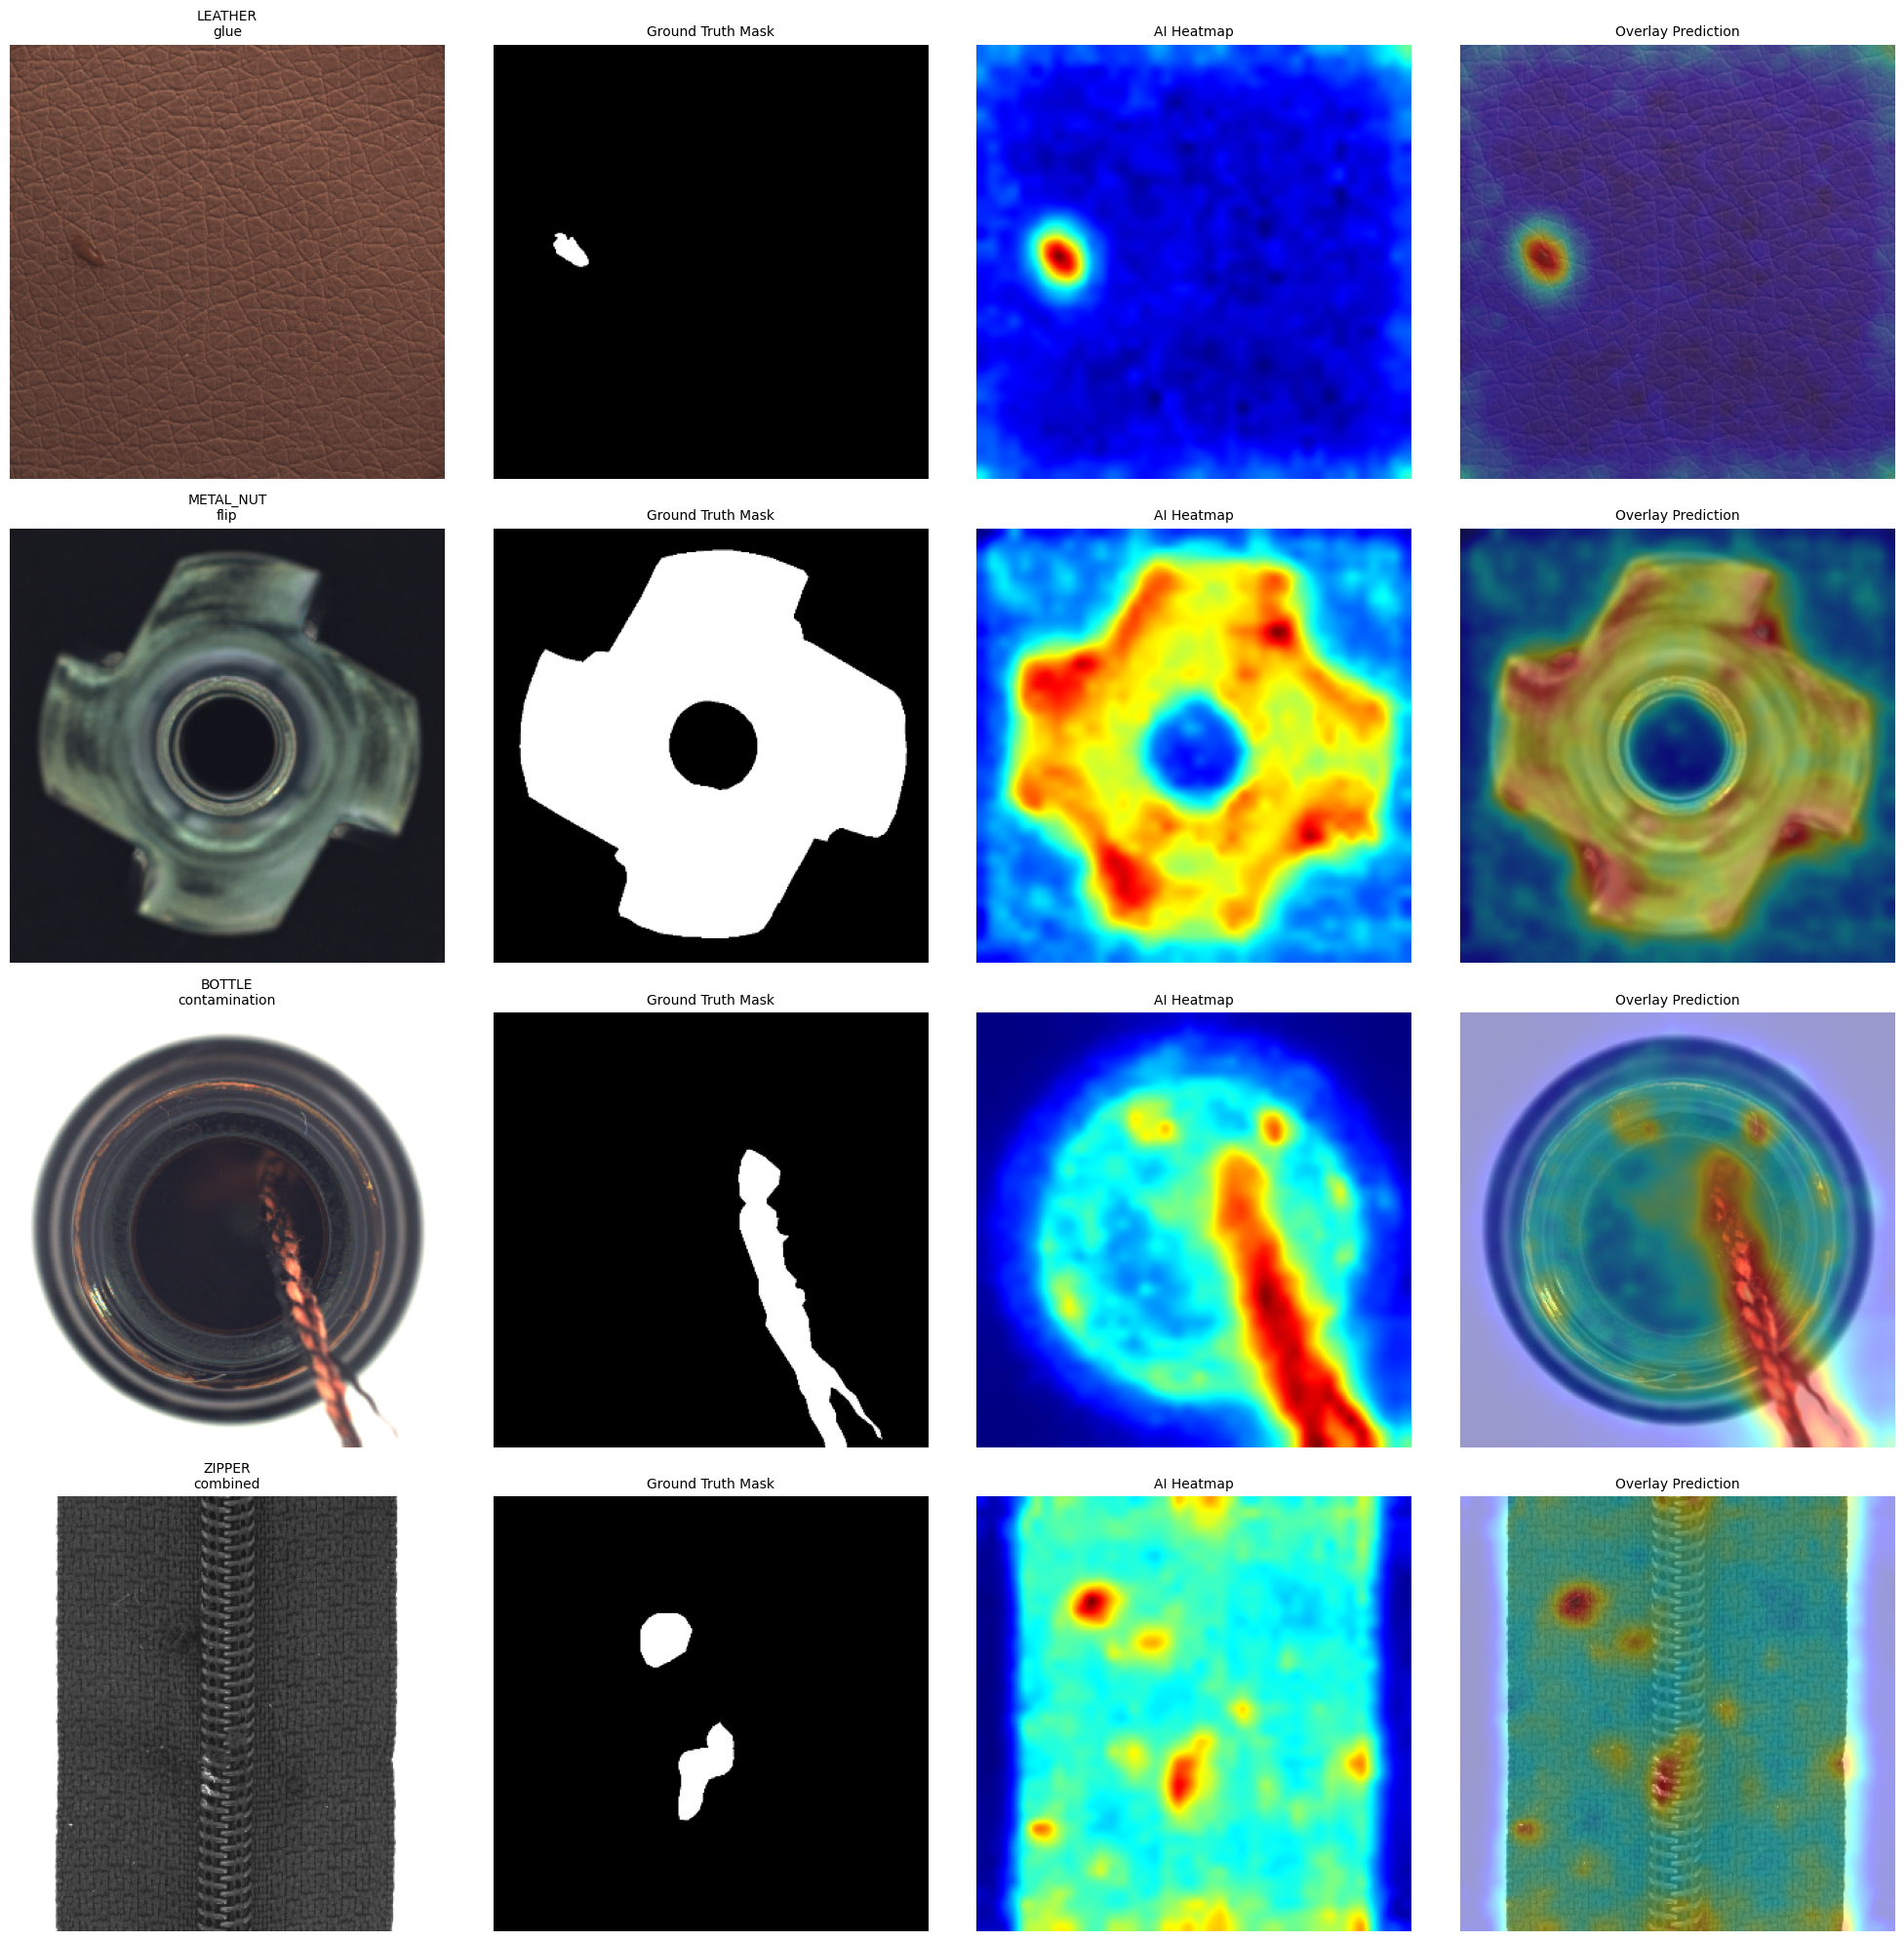

In [23]:
# ==========================================
# 🎨 VISUALIZATION LOOP
# ==========================================
def visualize_predictions():
    # Setup the backbone once
    backbone, features_storage = get_inference_backbone()
    
    # ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1, 3, 1, 1)
    
    # Kaggle Dataset Path
    root_dir = '/kaggle/input/mvtec-ad'
    if not os.path.exists(root_dir): root_dir = '/kaggle/input/mvtec-anomaly-detection'

    fig, axes = plt.subplots(len(TARGET_CATEGORIES), 4, figsize=(20, 5 * len(TARGET_CATEGORIES)))
    if len(TARGET_CATEGORIES) == 1: axes = [axes] # Handle single row case

    for idx, category in enumerate(TARGET_CATEGORIES):
        print(f"🔎 Visualizing: {category}...")
        
        # 1. Load Model Data
        checkpoint = load_checkpoint(category)
        if not checkpoint: continue
        
        memory_bank = checkpoint['memory_bank'].to(DEVICE)
        threshold = checkpoint['threshold']
        
        # 2. Find a Random Defective Image
        # We look into /test/ and exclude 'good' folder to ensure we see a defect
        test_path = os.path.join(root_dir, category, 'test')
        defect_folders = [d for d in os.listdir(test_path) if d != 'good']
        
        if not defect_folders:
            print("   No defect folders found (maybe only 'good' exists?)")
            continue
            
        random_defect = random.choice(defect_folders)
        image_files = glob.glob(os.path.join(test_path, random_defect, '*.png'))
        img_path = random.choice(image_files)
        
        # 3. Load Image
        original_img_cv = cv2.imread(img_path)
        original_img_cv = cv2.cvtColor(original_img_cv, cv2.COLOR_BGR2RGB)
        original_img_cv = cv2.resize(original_img_cv, (320, 320))
        
        # Prepare for Model
        img_tensor = original_img_cv.astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img_tensor).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
        img_tensor = (img_tensor - mean) / std
        
        # 4. Run Inference
        heatmap = compute_anomaly_map(backbone, features_storage, memory_bank, img_tensor)
        
        # 5. Process Heatmap for Display
        # Normalize heatmap 0-1 based on the threshold slightly for better viz
        # Typically we normalize min-max for visualization
        heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        heatmap_colored = cv2.applyColorMap(np.uint8(heatmap_norm * 255), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        # Create Binary Prediction Mask (based on saved threshold)
        pred_mask = (heatmap > threshold).astype(np.uint8) * 255
        
        # 6. Load Ground Truth Mask
        # MVTec structure: /test/defect_type/000.png -> /ground_truth/defect_type/000_mask.png
        gt_path = img_path.replace('/test/', '/ground_truth/').replace('.png', '_mask.png')
        if os.path.exists(gt_path):
            gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
            gt_mask = cv2.resize(gt_mask, (320, 320))
        else:
            gt_mask = np.zeros((320, 320), dtype=np.uint8) # No mask found
            
        # 7. Create Overlay (Superimpose heatmap on original)
        overlay = cv2.addWeighted(original_img_cv, 0.6, heatmap_colored, 0.4, 0)
        
        # 8. Plotting
        ax = axes[idx] if len(TARGET_CATEGORIES) > 1 else axes
        
        # Column 1: Original
        ax[0].imshow(original_img_cv)
        ax[0].set_title(f"{category.upper()}\n{random_defect}", fontsize=10)
        ax[0].axis('off')
        
        # Column 2: Ground Truth
        ax[1].imshow(gt_mask, cmap='gray')
        ax[1].set_title("Ground Truth Mask", fontsize=10)
        ax[1].axis('off')
        
        # Column 3: AI Heatmap
        ax[2].imshow(heatmap_colored)
        ax[2].set_title("AI Heatmap", fontsize=10)
        ax[2].axis('off')
        
        # Column 4: Prediction Overlay
        ax[3].imshow(overlay)
        ax[3].set_title("Overlay Prediction", fontsize=10)
        ax[3].axis('off')

    plt.tight_layout()
    plt.show()

# Run it!
visualize_predictions()